In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

In [46]:
# 1984:Q1 to 2015:Q4
start = datetime.datetime(1984, 10, 1)
end = datetime.datetime(2015, 12, 31)

# Quarterly U.S. real GDP from the FRED
ts = web.DataReader('GDPC1', 'fred', start, end)

# Convert to growth rates (in %)
ts = 4*np.log(ts).diff().dropna()

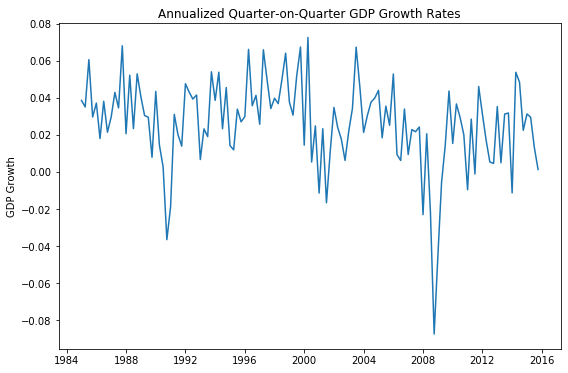

In [47]:
plt.figure(figsize=(9,6))
plt.plot(ts)
plt.ylabel('GDP Growth')
plt.title('Annualized Quarter-on-Quarter GDP Growth Rates')
plt.savefig('gdp-growth')

In [59]:
def ar_bayes(df, lags, tau): 
    y = df['GDPC1'][lags:]
    X = df
    # Model i data
    for col in X.columns:
        for l in range(1,lags+1):
            X.loc[:,col+"_L"+str(l)] = X[col].shift(l)
    X = df.drop(['GDPC1'], axis=1).dropna()
    from statsmodels.api import add_constant
    X = add_constant(X)
    T = len(ts) - lags
    
    from numpy.linalg import inv, det
    # Prior means and covariance matrices
    phi_0 = np.zeros(lags+1)
    V_0 = tau*np.eye(lags+1)
    
    # Posterior means and covariance matrices
    V_1 = inv(X.T @ X + inv(V_0))
    phi_1 = V_1 @ (X.T @ y + inv(V_0) @ phi_0.T)
    
    sigma2 = ((y - X @ phi_1).T @ (y - X @ phi_1))/T
    
    mdd = -T/2*np.log(2*np.pi*sigma2) \
                      - 0.5*np.log(det(V_0)/det(V_1)) \
            - 0.5/sigma2*(y.T @ y + phi_0.T @ inv(V_0) \
               @ phi_0 - phi_1.T @ inv(V_1) @ phi_1) 

    return {'phi_1':phi_1, 'V_1': V_1, 'mdd':mdd} 

In [60]:
mdds = []
for i in range(1, 5):
    mdds.append(ar_bayes(ts[:], i, tau=10)['mdd'])
mdds

[285.02600789399827, 284.2758819260932, 282.359071778994, 279.41203536257274]

In [61]:
mod_prior = [0.25, 0.25, 0.25, 0.25]
denom = 0.25*np.sum(np.exp(mdds))
mod_post_prob = []
for i in range(4):
    mod_post_prob.append(0.25*np.exp(mdds[i])/denom)
mod_post_prob

[0.6470739827781313,
 0.30561760617883654,
 0.044948820503103955,
 0.002359590539928073]

In [62]:
# Generate grid
hyper_mdds = []
taus = [1/1000] * 6
for i in range(1,5):
    taus[i+1] = taus[i]*10
    hyper_mdds.append(ar_bayes(ts[:], lags=1, tau=taus[i])['mdd'])
hyper_mdds

[240.34705940735307, 256.87800405692195, 278.64067460302834, 282.9263921583983]